# P8

In [1]:
nb_epochs = 20

## import

In [4]:
from skimage.io import imshow, imread, imsave, use_plugin
from skimage.transform import resize

import glob
import os

from tensorflow.keras.utils import Sequence 

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Activation, Dropout, Reshape, Permute
from tensorflow.keras.optimizers import Adadelta, Nadam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
from tensorflow.keras.losses import binary_crossentropy

import numpy as np
from tensorflow.keras.preprocessing.image import load_img

import skimage.io as io

import time
from matplotlib import pyplot as plt

import tensorflow as tf
import keras

import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa
import imageio

# module used for image segmentation models
# https://segmentation-models.readthedocs.io/en/latest/tutorial.html
from segmentation_models import Unet, FPN, Linknet, PSPNet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss, dice_loss, jaccard_loss, binary_crossentropy
from segmentation_models.metrics import iou_score
from keras import backend as K


Segmentation Models: using `keras` framework.


## fonctions utilitaires

In [5]:
cats = {'void': [0, 1, 2, 3, 4, 5, 6],
 'flat': [7, 8, 9, 10],
 'construction': [11, 12, 13, 14, 15, 16],
 'object': [17, 18, 19, 20],
 'nature': [21, 22],
 'sky': [23],
 'human': [24, 25],
 'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]}

# convert img labels from 35 to 8 class
def class_35_to_8(list_img):
    mask_8class = []
    # pour chaque mask, create 8 class mask
    for img in list_img:
      mask = np.zeros((img.shape[0], img.shape[1], 8), dtype='uint8')
      for i in range(-1, 34):
          if i in cats['void']:
              mask[:,:,0] = np.logical_or(mask[:,:,0],(img==i))
          elif i in cats['flat']:
              mask[:,:,1] = np.logical_or(mask[:,:,1],(img==i))
          elif i in cats['construction']:
              mask[:,:,2] = np.logical_or(mask[:,:,2],(img==i))
          elif i in cats['object']:
              mask[:,:,3] = np.logical_or(mask[:,:,3],(img==i))
          elif i in cats['nature']:
              mask[:,:,4] = np.logical_or(mask[:,:,4],(img==i))
          elif i in cats['sky']:
              mask[:,:,5] = np.logical_or(mask[:,:,5],(img==i))
          elif i in cats['human']:
              mask[:,:,6] = np.logical_or(mask[:,:,6],(img==i))
          elif i in cats['vehicle']:
              mask[:,:,7] = np.logical_or(mask[:,:,7],(img==i))
      mask_8class.append(mask)
    mask_8class = np.array(mask_8class).astype(np.float32)#.astype(int)#.astype(np.float32)
    print(mask_8class.shape)
    return mask_8class

In [6]:
# afficher image 8 class en niveau de gris
def display_imarge(img):
    imarge = []
    for row in img:
        imarge_row = []
        for pix in row:
            if pix[0] > 0.5: merge = .1
            elif pix[1] > 0.5: merge = .2
            elif pix[2] > 0.5: merge = .3
            elif pix[3] > 0.5: merge = .4
            elif pix[4] > 0.5: merge = .5
            elif pix[5] > 0.5: merge = .6
            elif pix[6] > 0.5: merge = .7
            else: merge = .8
            imarge_row.append(merge) 
        imarge.append(imarge_row)
    imarge = np.array(imarge)
    imshow(imarge, vmin = 0, vmax = 0.8)
    return imarge

In [7]:
# afficher la learning curve
def afficher_resultats(hist,name='inconnue'):
    metric = hist.history['dice_metric'][-1]
    print(metric)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    return metric

In [8]:
# load img from files names
def read_img(files, taille = 256, color_mode = 'rgb'):
    data = []
    for i in files:   
        imageee=load_img(i, color_mode=color_mode, target_size= (taille,taille))
        imageee=np.array(imageee)
        data.append(imageee)
    X_dataVAL = np.array(data)
    print(X_dataVAL.shape)
    return X_dataVAL
    

## load data
chargement des données (on en garde 1000 sur les 5000 à disposition).\
On a besoin de 2 formats d'images différents (256 * 256 et 384 * 384 pour PSPNet).

In [1]:
My_path = 'C:/Users/eloir/Downloads/'

In [10]:
My_path_input = 'D:/P8_Cityscapes_leftImg8bit_trainvaltest(1)/leftImg8bit/'
My_path_mask = 'D:/P8_Cityscapes_gtFine_trainvaltest(1)/gtFine/'

In [11]:
files_input = sorted(glob.glob(My_path_input+'train/*/*'))
files_mask = sorted(glob.glob(My_path_mask+'train/*/*labelIds.png'))

files_inputTEST = sorted(glob.glob(My_path_input+'test/*/*'))
files_maskTEST = sorted(glob.glob(My_path_mask+'test/*/*labelIds.png'))

files_inputVAL = sorted(glob.glob(My_path_input+'val/*/*'))
files_maskVAL = sorted(glob.glob(My_path_mask+'val/*/*labelIds.png'))

In [12]:
len(files_mask)+len(files_maskTEST)+len(files_maskVAL)

5000

In [13]:
files_mask = files_mask[:800]
files_input = files_input[:800]

files_maskTEST = files_maskTEST[:100]
files_inputTEST = files_inputTEST[:100]

files_maskVAL = files_maskVAL[:100]
files_inputVAL = files_inputVAL[:100]

In [14]:
len(files_input)

800

In [15]:
len(files_maskTEST)

100

In [16]:
io.use_plugin('matplotlib', 'imshow')

In [17]:
# load img reducing to 256*256 size
X_dataVAL = read_img(files_inputVAL, taille = 256)
X_dataTEST = read_img(files_inputTEST, taille = 256)
X_data = read_img(files_input, taille = 256)
y_dataVAL = read_img(files_maskVAL, taille = 256, color_mode='grayscale')
y_dataTEST = read_img(files_maskTEST, taille = 256, color_mode='grayscale')
y_data = read_img(files_mask, taille = 256, color_mode='grayscale')

(100, 256, 256, 3)
(100, 256, 256, 3)
(800, 256, 256, 3)
(100, 256, 256)
(100, 256, 256)
(800, 256, 256)


In [293]:
X_dataVAL384 = read_img(files_inputVAL[:80], taille = 384)
X_dataTEST384 = read_img(files_inputTEST[:80], taille = 384)
X_data384 = read_img(files_input[:300], taille = 384)
y_dataVAL384 = read_img(files_maskVAL[:80], taille = 384, color_mode='grayscale')
y_dataTEST384 = read_img(files_maskTEST[:80], taille = 384, color_mode='grayscale')
y_data384 = read_img(files_mask[:300], taille = 384, color_mode='grayscale')
#MemoryError: Unable to allocate 3.52 GiB for an array with shape (800, 384, 384, 8) and data type float32

(80, 384, 384, 3)
(80, 384, 384, 3)
(300, 384, 384, 3)
(80, 384, 384)
(80, 384, 384)
(300, 384, 384)


In [297]:
# convert output img from 35 to 8 class
mask_8classVAL = class_35_to_8(y_dataVAL)
mask_8classTEST = class_35_to_8(y_dataTEST)
mask_8class = class_35_to_8(y_data)

mask_8classVAL384 = class_35_to_8(y_dataVAL384)
mask_8classTEST384 = class_35_to_8(y_dataTEST384)
mask_8class384 = class_35_to_8(y_data384)

(100, 256, 256, 8)
(100, 256, 256, 8)
(800, 256, 256, 8)
(80, 384, 384, 8)
(80, 384, 384, 8)
(300, 384, 384, 8)


## metriques
    On utilisera le coefficient de Dice pour evaluer la performance des modeles. Pour entrainer les modeles, on comparera la fonction de cout associée au coefficient de Dice et l'indice de Jaccard. Ces 2 métriques mesurent la similarité entre 2 echantillons.

In [20]:
# same idea for dice and jaccard metrics
def dice_metric(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_metric(y_true, y_pred)
    return loss

def total_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + (3*dice_loss(y_true, y_pred))
    return loss

def jaccard_metric(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    Jaccard = (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)
    return Jaccard

def jaccard_loss(y_true, y_pred):
    return 1-jaccard_metric(y_true, y_pred)

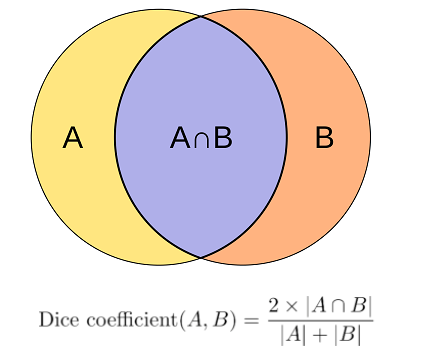

## generateurs data aug
On créé nos augmentateurs de données qui serviront pour l'entrainement du modèle final (voir fin).

In [21]:
batch_size = 16

samples = 50
samples_limit_train = 25
steps = samples_limit_train//batch_size
img_height, img_width = 256, 256
classes = 8
filters_n = 64

In [22]:
ia.seed(1)

In [258]:
# sequence de modification d'img
seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True) # apply augmenters in random order

# augmenter class object 
class seg_gen(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        # take ("samples_limit_train" number of) random img from the set
        idx = np.random.randint(0, samples_limit_train, self.batch_size)
        batch_x, batch_y = [], []
        seq_det = seq.to_deterministic()
        
        for i in idx:
            _image = self.x[i]  
            img_mask = self.y[i] 
            
            images_aug_i = seq_det(image=_image)
            segmaps_aug_i = seq_det(image=img_mask)
            
            batch_y.append(img_mask)
            batch_x.append(images_aug_i)
        
        return tf.image.resize(batch_x, (256,256)), tf.image.resize(batch_y, (256,256))

In [25]:
# sequence de modification d'img sur les img de validation (utilise les mêmes transformations que le generateur "seg_gen2")
class seg_gen_validation(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        print("get item !")
        # take ("samples_limit_train" number of) random img from the set
        idx = np.random.randint(samples_limit_train, samples, self.batch_size)
        batch_x, batch_y = [], []

        for i in idx:
            _image = self.x[i]  
            img_mask = self.y[i] 
            batch_y.append(img_mask)
            batch_x.append(_image)
        
        return np.array(batch_x), np.array(batch_y)

## models
On va entrainer plusieurs modeles pour comparer leurs performances.\
Ci dessous l'image utiliser en tant qu'exemple pour chaque modeles.

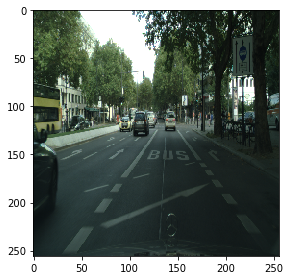

In [26]:
imshow(X_dataTEST[0])

In [27]:
liste_resultats = {}

In [173]:
# load your data
x_train2, y_train, x_val2, y_val = X_data, mask_8class, X_dataVAL, mask_8classVAL

BACKBONE = 'resnet34'
#BACKBONE = 'mobilenetv2'

# prepare data for mobilenetv2/resnet34
preprocess_input = get_preprocessing(BACKBONE)
x_train = preprocess_input(x_train2)
x_val = preprocess_input(x_val2)

# prepare data for vgg16
preprocess_input_vgg16 = get_preprocessing('vgg16')
x_train_vgg16 = preprocess_input_vgg16(x_train2)
x_val_vgg16 = preprocess_input_vgg16(x_val2)

In [29]:
import segmentation_models as sm

sm.set_framework('tf.keras')

sm.framework()

'tf.keras'

### PSPNet (jaccard) 

**/!\ peu de data, risque de crash /!\** (images + lourdes 384 * 384)

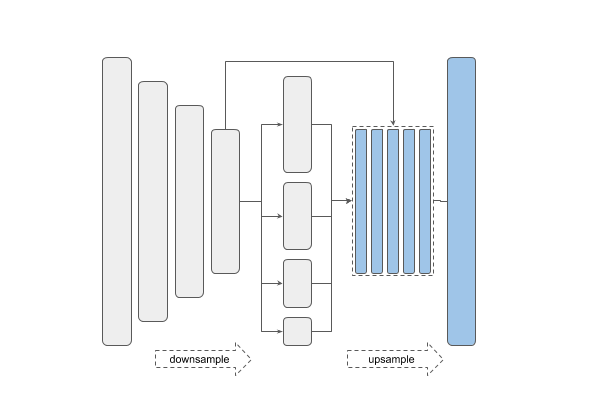

In [299]:
x_train384, y_train384, x_val384, y_val384 = X_data384, mask_8class384, X_dataVAL384, mask_8classVAL384

# preprocess input
x_train384 = preprocess_input(x_train384)
x_val384 = preprocess_input(x_val384)

In [300]:
model = PSPNet(BACKBONE, encoder_weights='imagenet', classes=8, input_shape=(384, 384, 3))
model.compile('Adam', loss=jaccard_loss, metrics=[dice_metric])

In [301]:

# fit model
start = time.time()
history = model.fit(
    x=x_train384,
    y=y_train384,
    batch_size=16,
    epochs=nb_epochs,
    validation_data=(x_val384, y_val384)
    #callbacks=[model_checkpoint_callback]
    )
end = time.time()
training_time = end - start
training_time

Epoch 1/20
19/19 [==============================] - 457s 13s/step - loss: 0.4606 - dice_metric: 0.6904
Epoch 2/20
19/19 [==============================] - 193s 10s/step - loss: 0.3642 - dice_metric: 0.7776
Epoch 3/20
19/19 [==============================] - 188s 10s/step - loss: 0.3344 - dice_metric: 0.7989
Epoch 4/20
19/19 [==============================] - 188s 10s/step - loss: 0.3118 - dice_metric: 0.8148
Epoch 5/20
19/19 [==============================] - 190s 10s/step - loss: 0.3023 - dice_metric: 0.8219
Epoch 6/20
19/19 [==============================] - 190s 10s/step - loss: 0.2909 - dice_metric: 0.8293
Epoch 7/20
19/19 [==============================] - 190s 10s/step - loss: 0.2832 - dice_metric: 0.8349
Epoch 8/20
19/19 [==============================] - 189s 10s/step - loss: 0.2771 - dice_metric: 0.8392
Epoch 9/20
19/19 [==============================] - 192s 10s/step - loss: 0.2742 - dice_metric: 0.8410
Epoch 10/20
19/19 [==============================] - 188s 10s/step - loss

4064.658495903015

In [ ]:
afficher_resultats(history,'jaccard_loss')# jaccard loss

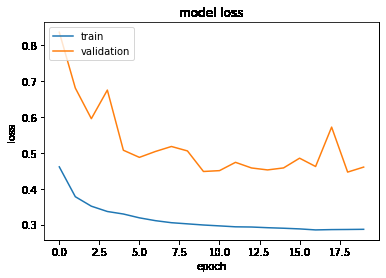

Evaluate on test data
4/4 [==============================] - 13s 2s/step - loss: 1.0000 - dice_metric: 1.1800e-06
test loss, test acc: [0.9999994039535522, 1.1799651247201837e-06]


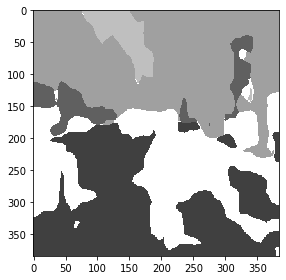

In [303]:
predd = model.predict(X_dataTEST384[:1])
display_imarge(predd[0])
print("Evaluate on test data")
results = model.evaluate(X_dataTEST384[:50], mask_8classTEST384[:50], batch_size=16)
print("test loss, test acc:", results)

In [304]:
liste_resultats['PSPNet_jaccard'] = {"metric":results[-1],"time":training_time}

In [305]:
#model.save(My_path+'models_full_DATA/'+'PSPNet_jaccard_20_300')

INFO:tensorflow:Assets written to: C:/Users/eloir/Downloads/models_full_DATA/PSPNet_jaccard_20_300\assets


### Linknet (jaccard)

Model simple (par rapport à Unet)

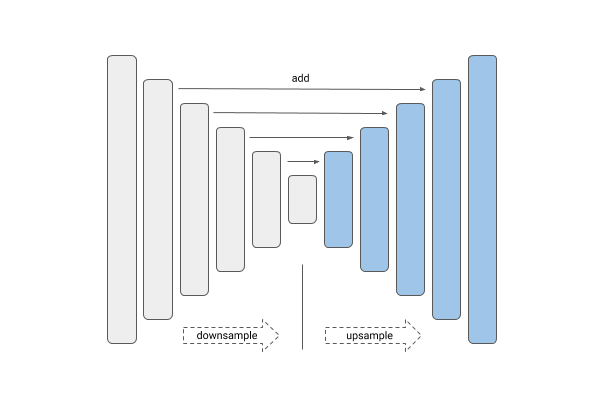

In [36]:
model = Linknet(BACKBONE, encoder_weights='imagenet', classes=8)
model.compile('Adam', loss=jaccard_loss, metrics=[dice_metric])

In [37]:
# fit model
start = time.time()
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=16,
    epochs=nb_epochs,
    validation_data=(x_val, y_val)
    )
end = time.time()
training_time = end - start
training_time

Epoch 1/20
50/50 [==============================] - 309s 6s/step - loss: 0.7146 - dice_metric: 0.4312 - val_loss: 0.8631 - val_dice_metric: 0.2400
Epoch 2/20
50/50 [==============================] - 305s 6s/step - loss: 0.3547 - dice_metric: 0.7820 - val_loss: 0.7680 - val_dice_metric: 0.3759
Epoch 3/20
50/50 [==============================] - 312s 6s/step - loss: 0.2487 - dice_metric: 0.8578 - val_loss: 0.5834 - val_dice_metric: 0.5887
Epoch 4/20
50/50 [==============================] - 316s 6s/step - loss: 0.2245 - dice_metric: 0.8733 - val_loss: 0.4350 - val_dice_metric: 0.7184
Epoch 5/20
50/50 [==============================] - 315s 6s/step - loss: 0.2036 - dice_metric: 0.8864 - val_loss: 0.3465 - val_dice_metric: 0.7863
Epoch 6/20
50/50 [==============================] - 316s 6s/step - loss: 0.1889 - dice_metric: 0.8956 - val_loss: 0.3282 - val_dice_metric: 0.8007
Epoch 7/20
50/50 [==============================] - 316s 6s/step - loss: 0.1878 - dice_metric: 0.8962 - val_loss: 0.28

6288.150264501572

In [ ]:
afficher_resultats(history,'jaccard_loss')# jaccard loss

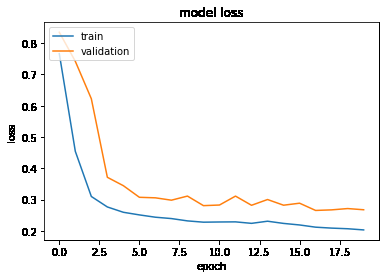

Evaluate on test data
1/1 [==============================] - 8s 8s/step - loss: 0.9703 - dice_metric: 0.0578
test loss, test acc: [0.9702564477920532, 0.057768724858760834]


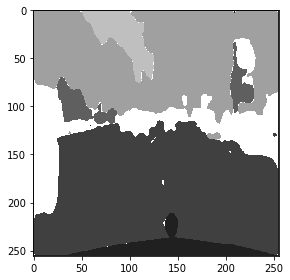

In [38]:
predd = model.predict(X_dataTEST[:1])
display_imarge(predd[0])
print("Evaluate on test data")
results = model.evaluate(X_dataTEST, mask_8classTEST, batch_size=128)
print("test loss, test acc:", results)

In [39]:
liste_resultats['LinkNet_jaccard'] = {"metric":results[-1],"time":training_time}

In [40]:
#model.save(My_path+'models_full_DATA/'+'LinkNet_jaccard')

### FPN (jaccard)
Feature Pyramid Network

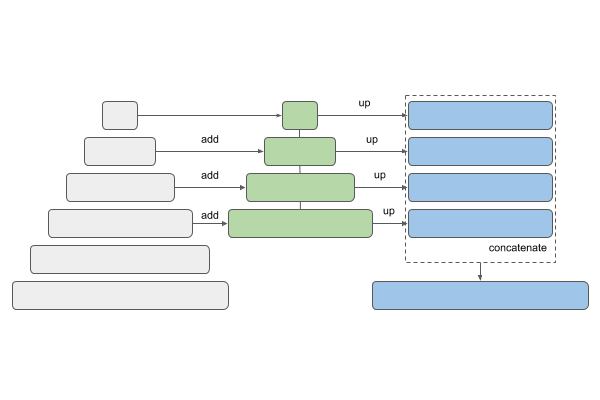

In [41]:
model = FPN(BACKBONE, encoder_weights='imagenet', classes=8, input_shape=(256, 256, 3))
model.compile('Adam', loss=jaccard_loss, metrics=[dice_metric])

In [42]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 256, 256, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d_68 (ZeroPadding  (None, 262, 262, 3)  0          ['bn_data[0][0]']                
 2D)                                                                                              
                                                                                            

 zero_padding2d_74 (ZeroPadding  (None, 66, 66, 64)  0           ['stage1_unit3_relu1[0][0]']     
 2D)                                                                                              
                                                                                                  
 stage1_unit3_conv1 (Conv2D)    (None, 64, 64, 64)   36864       ['zero_padding2d_74[0][0]']      
                                                                                                  
 stage1_unit3_bn2 (BatchNormali  (None, 64, 64, 64)  256         ['stage1_unit3_conv1[0][0]']     
 zation)                                                                                          
                                                                                                  
 stage1_unit3_relu2 (Activation  (None, 64, 64, 64)  0           ['stage1_unit3_bn2[0][0]']       
 )                                                                                                
          

 zation)                                                                                          
                                                                                                  
 stage2_unit3_relu2 (Activation  (None, 32, 32, 128)  0          ['stage2_unit3_bn2[0][0]']       
 )                                                                                                
                                                                                                  
 zero_padding2d_81 (ZeroPadding  (None, 34, 34, 128)  0          ['stage2_unit3_relu2[0][0]']     
 2D)                                                                                              
                                                                                                  
 stage2_unit3_conv2 (Conv2D)    (None, 32, 32, 128)  147456      ['zero_padding2d_81[0][0]']      
                                                                                                  
 add_37 (A

 2D)                                                                                              
                                                                                                  
 stage3_unit2_conv2 (Conv2D)    (None, 16, 16, 256)  589824      ['zero_padding2d_87[0][0]']      
                                                                                                  
 add_40 (Add)                   (None, 16, 16, 256)  0           ['stage3_unit2_conv2[0][0]',     
                                                                  'add_39[0][0]']                 
                                                                                                  
 stage3_unit3_bn1 (BatchNormali  (None, 16, 16, 256)  1024       ['add_40[0][0]']                 
 zation)                                                                                          
                                                                                                  
 stage3_un

 zation)                                                                                          
                                                                                                  
 stage3_unit6_relu1 (Activation  (None, 16, 16, 256)  0          ['stage3_unit6_bn1[0][0]']       
 )                                                                                                
                                                                                                  
 zero_padding2d_94 (ZeroPadding  (None, 18, 18, 256)  0          ['stage3_unit6_relu1[0][0]']     
 2D)                                                                                              
                                                                                                  
 stage3_unit6_conv1 (Conv2D)    (None, 16, 16, 256)  589824      ['zero_padding2d_94[0][0]']      
                                                                                                  
 stage3_un

 g2D)                                                                                             
                                                                                                  
 stage4_unit3_conv1 (Conv2D)    (None, 8, 8, 512)    2359296     ['zero_padding2d_100[0][0]']     
                                                                                                  
 stage4_unit3_bn2 (BatchNormali  (None, 8, 8, 512)   2048        ['stage4_unit3_conv1[0][0]']     
 zation)                                                                                          
                                                                                                  
 stage4_unit3_relu2 (Activation  (None, 8, 8, 512)   0           ['stage4_unit3_bn2[0][0]']       
 )                                                                                                
                                                                                                  
 zero_padd

                                                                                                  
 segm_stage2a_relu (Activation)  (None, 128, 128, 12  0          ['segm_stage2a_bn[0][0]']        
                                8)                                                                
                                                                                                  
 segm_stage3b_conv (Conv2D)     (None, 64, 64, 128)  147456      ['segm_stage3a_relu[0][0]']      
                                                                                                  
 segm_stage4b_conv (Conv2D)     (None, 32, 32, 128)  147456      ['segm_stage4a_relu[0][0]']      
                                                                                                  
 segm_stage5b_conv (Conv2D)     (None, 16, 16, 128)  147456      ['segm_stage5a_relu[0][0]']      
                                                                                                  
 segm_stag

use_multiprocessing=True avec/sans => même temps

In [45]:
# fit model
start = time.time()
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=16,
    epochs=nb_epochs,
    validation_data=(x_val, y_val)
    )
end = time.time()
training_time = end - start
training_time

Epoch 1/20
50/50 [==============================] - 1145s 23s/step - loss: 0.3605 - dice_metric: 0.7716 - val_loss: 0.6304 - val_dice_metric: 0.5349
Epoch 2/20
50/50 [==============================] - 1129s 23s/step - loss: 0.2309 - dice_metric: 0.8693 - val_loss: 0.3906 - val_dice_metric: 0.7549
Epoch 3/20
50/50 [==============================] - 1117s 22s/step - loss: 0.2034 - dice_metric: 0.8866 - val_loss: 0.3540 - val_dice_metric: 0.7810
Epoch 4/20
50/50 [==============================] - 1135s 23s/step - loss: 0.1925 - dice_metric: 0.8933 - val_loss: 0.2922 - val_dice_metric: 0.8253
Epoch 5/20
50/50 [==============================] - 1130s 23s/step - loss: 0.1862 - dice_metric: 0.8972 - val_loss: 0.3348 - val_dice_metric: 0.7928
Epoch 6/20
50/50 [==============================] - 1132s 23s/step - loss: 0.1833 - dice_metric: 0.8989 - val_loss: 0.3253 - val_dice_metric: 0.8048
Epoch 7/20
50/50 [==============================] - 1131s 23s/step - loss: 0.1754 - dice_metric: 0.9037 - 

22460.50908112526

In [ ]:
afficher_resultats(history,'jaccard_loss')# jaccard loss

In [46]:
# sans 293 / avec 290 (, use_multiprocessing=True)

Evaluate on test data
7/7 [==============================] - 28s 4s/step - loss: 0.9591 - dice_metric: 0.0806
test loss, test acc: [0.9591286182403564, 0.08055661618709564]


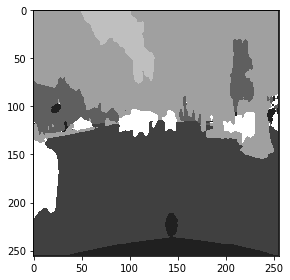

In [47]:
predd = model.predict(X_dataTEST[:1])
display_imarge(predd[0])
print("Evaluate on test data")
results = model.evaluate(X_dataTEST, mask_8classTEST, batch_size=16)
print("test loss, test acc:", results)

In [48]:
liste_resultats['FPN_jaccard'] = {"metric":results[-1],"time":training_time}

In [49]:
#model.save(My_path+'models_full_DATA/'+'FPN_jaccard')

## Choix de l'encoder

### Unet (resNet)

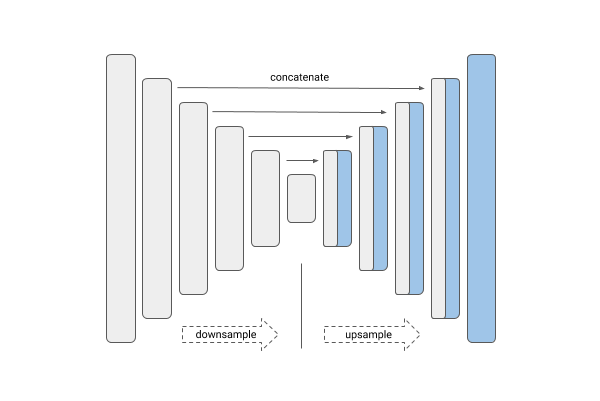

In [50]:
model = Unet(BACKBONE, encoder_weights='imagenet', classes=8)
model.compile('Adam', loss=jaccard_loss, metrics=[dice_metric])

In [51]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d_102 (ZeroPaddin  (None, None, None,   0          ['bn_data[0][0]']                
 g2D)                           3)                                                          

                                                                                                  
 stage1_unit3_bn1 (BatchNormali  (None, None, None,   256        ['add_49[0][0]']                 
 zation)                        64)                                                               
                                                                                                  
 stage1_unit3_relu1 (Activation  (None, None, None,   0          ['stage1_unit3_bn1[0][0]']       
 )                              64)                                                               
                                                                                                  
 zero_padding2d_108 (ZeroPaddin  (None, None, None,   0          ['stage1_unit3_relu1[0][0]']     
 g2D)                           64)                                                               
                                                                                                  
 stage1_un

                                128)                              'add_51[0][0]']                 
                                                                                                  
 stage2_unit3_bn1 (BatchNormali  (None, None, None,   512        ['add_52[0][0]']                 
 zation)                        128)                                                              
                                                                                                  
 stage2_unit3_relu1 (Activation  (None, None, None,   0          ['stage2_unit3_bn1[0][0]']       
 )                              128)                                                              
                                                                                                  
 zero_padding2d_114 (ZeroPaddin  (None, None, None,   0          ['stage2_unit3_relu1[0][0]']     
 g2D)                           128)                                                              
          

 add_55 (Add)                   (None, None, None,   0           ['stage3_unit1_conv2[0][0]',     
                                256)                              'stage3_unit1_sc[0][0]']        
                                                                                                  
 stage3_unit2_bn1 (BatchNormali  (None, None, None,   1024       ['add_55[0][0]']                 
 zation)                        256)                                                              
                                                                                                  
 stage3_unit2_relu1 (Activation  (None, None, None,   0          ['stage3_unit2_bn1[0][0]']       
 )                              256)                                                              
                                                                                                  
 zero_padding2d_120 (ZeroPaddin  (None, None, None,   0          ['stage3_unit2_relu1[0][0]']     
 g2D)     

                                                                                                  
 stage3_unit5_bn1 (BatchNormali  (None, None, None,   1024       ['add_58[0][0]']                 
 zation)                        256)                                                              
                                                                                                  
 stage3_unit5_relu1 (Activation  (None, None, None,   0          ['stage3_unit5_bn1[0][0]']       
 )                              256)                                                              
                                                                                                  
 zero_padding2d_126 (ZeroPaddin  (None, None, None,   0          ['stage3_unit5_relu1[0][0]']     
 g2D)                           256)                                                              
                                                                                                  
 stage3_un

                                512)                              'stage4_unit1_sc[0][0]']        
                                                                                                  
 stage4_unit2_bn1 (BatchNormali  (None, None, None,   2048       ['add_61[0][0]']                 
 zation)                        512)                                                              
                                                                                                  
 stage4_unit2_relu1 (Activation  (None, None, None,   0          ['stage4_unit2_bn1[0][0]']       
 )                              512)                                                              
                                                                                                  
 zero_padding2d_132 (ZeroPaddin  (None, None, None,   0          ['stage4_unit2_relu1[0][0]']     
 g2D)                           512)                                                              
          

                                                                                                  
 decoder_stage0b_relu (Activati  (None, None, None,   0          ['decoder_stage0b_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 decoder_stage1_upsampling (UpS  (None, None, None,   0          ['decoder_stage0b_relu[0][0]']   
 ampling2D)                     256)                                                              
                                                                                                  
 decoder_stage1_concat (Concate  (None, None, None,   0          ['decoder_stage1_upsampling[0][0]
 nate)                          384)                             ',                               
                                                                  'stage3_unit1_relu1[0][0]']     
          

                                16)                              ']                               
                                                                                                  
 decoder_stage4a_bn (BatchNorma  (None, None, None,   64         ['decoder_stage4a_conv[0][0]']   
 lization)                      16)                                                               
                                                                                                  
 decoder_stage4a_relu (Activati  (None, None, None,   0          ['decoder_stage4a_bn[0][0]']     
 on)                            16)                                                               
                                                                                                  
 decoder_stage4b_conv (Conv2D)  (None, None, None,   2304        ['decoder_stage4a_relu[0][0]']   
                                16)                                                               
          

In [52]:
# fit model
start = time.time()
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=16,
    epochs=nb_epochs,
    validation_data=(x_val, y_val)
    )
end = time.time()
training_time = end - start
training_time

Epoch 1/20
50/50 [==============================] - 463s 9s/step - loss: 0.6972 - dice_metric: 0.4531 - val_loss: 0.8278 - val_dice_metric: 0.2893
Epoch 2/20
50/50 [==============================] - 443s 9s/step - loss: 0.3384 - dice_metric: 0.7945 - val_loss: 0.8481 - val_dice_metric: 0.2628
Epoch 3/20
50/50 [==============================] - 443s 9s/step - loss: 0.2378 - dice_metric: 0.8649 - val_loss: 0.7148 - val_dice_metric: 0.4401
Epoch 4/20
50/50 [==============================] - 443s 9s/step - loss: 0.2150 - dice_metric: 0.8793 - val_loss: 0.4497 - val_dice_metric: 0.7050
Epoch 5/20
50/50 [==============================] - 443s 9s/step - loss: 0.1964 - dice_metric: 0.8909 - val_loss: 0.2999 - val_dice_metric: 0.8194
Epoch 6/20
50/50 [==============================] - 443s 9s/step - loss: 0.1853 - dice_metric: 0.8977 - val_loss: 0.2800 - val_dice_metric: 0.8323
Epoch 7/20
50/50 [==============================] - 443s 9s/step - loss: 0.1810 - dice_metric: 0.9003 - val_loss: 0.29

8857.301687955856

0.9255674481391907


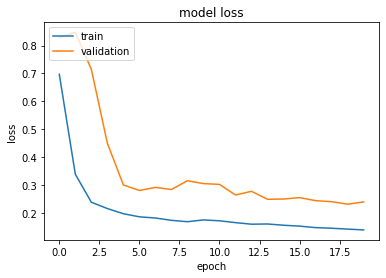

0.9255674481391907

In [53]:
afficher_resultats(history,'jaccard_loss')# jaccard loss

Evaluate on test data
1/1 [==============================] - 10s 10s/step - loss: 0.9704 - dice_metric: 0.0575
test loss, test acc: [0.9703837633132935, 0.05752857029438019]


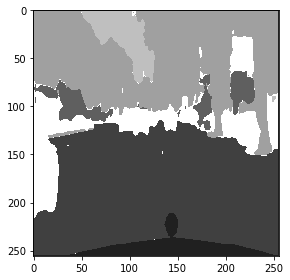

In [54]:
predd = model.predict(X_dataTEST[:1])
#imshow(predd[0][:,:,0])#void
display_imarge(predd[0])
print("Evaluate on test data")
results = model.evaluate(X_dataTEST, mask_8classTEST, batch_size=128)
print("test loss, test acc:", results)

In [55]:
liste_resultats['Unet_jaccard'] = {"metric":results[-1],"time":training_time}
#17508

In [56]:
#model.save(My_path+'models_full_DATA/'+'Unet_jaccard')

### Unet (vgg16)


In [57]:
model = Unet('vgg16', encoder_weights='imagenet', classes=8)
model.compile('Adam', loss=jaccard_loss, metrics=[dice_metric])

In [58]:
# fit model
start = time.time()
history = model.fit(
    x=x_train_vgg16,
    y=y_train,
    batch_size=16,
    epochs=nb_epochs,
    validation_data=(x_val, y_val)
    )
end = time.time()
training_time = end - start
training_time

Epoch 1/20
50/50 [==============================] - 820s 16s/step - loss: 0.6898 - dice_metric: 0.4661 - val_loss: 0.8713 - val_dice_metric: 0.2288
Epoch 2/20
50/50 [==============================] - 811s 16s/step - loss: 0.4737 - dice_metric: 0.6882 - val_loss: 0.6962 - val_dice_metric: 0.4626
Epoch 3/20
50/50 [==============================] - 818s 16s/step - loss: 0.3625 - dice_metric: 0.7783 - val_loss: 0.6951 - val_dice_metric: 0.4639
Epoch 4/20
50/50 [==============================] - 807s 16s/step - loss: 0.3322 - dice_metric: 0.8006 - val_loss: 0.6700 - val_dice_metric: 0.4947
Epoch 5/20
50/50 [==============================] - 806s 16s/step - loss: 0.3119 - dice_metric: 0.8150 - val_loss: 0.6327 - val_dice_metric: 0.5342
Epoch 6/20
50/50 [==============================] - 813s 16s/step - loss: 0.2977 - dice_metric: 0.8249 - val_loss: 0.6354 - val_dice_metric: 0.5324
Epoch 7/20
50/50 [==============================] - 809s 16s/step - loss: 0.2817 - dice_metric: 0.8357 - val_los

16445.96554660797

0.8788152933120728


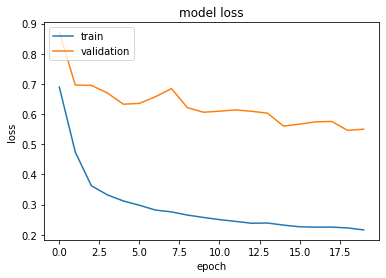

0.8788152933120728

In [59]:
afficher_resultats(history,'jaccard_loss')

Evaluate on test data
1/1 [==============================] - 28s 28s/step - loss: 0.9941 - dice_metric: 0.0118
test loss, test acc: [0.9940568804740906, 0.011815889738500118]


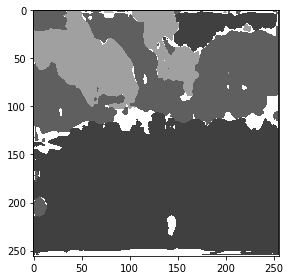

In [60]:
predd = model.predict(X_dataTEST[:1])
display_imarge(predd[0])
print("Evaluate on test data")
results = model.evaluate(X_dataTEST, mask_8classTEST, batch_size=128)
print("test loss, test acc:", results)

In [61]:
liste_resultats['Unet_vgg16'] = {"metric":results[-1],"time":training_time}

In [62]:
#model.save(My_path+'models_full_DATA/'+'Unet_vgg16')

## model retenu/choix fonctions loss
L'encoder Resnet à de meilleurs perfs.\
On va utiliser d'autres fonctions de cout que jaccard_loss (deja été utilisé plus haut)

### Unet (dice_loss)


In [63]:
# define model
model = Unet(BACKBONE, encoder_weights='imagenet', classes=8)
model.compile('Adam', loss=dice_loss, metrics=[iou_score,dice_metric])

In [64]:
# fit model
start = time.time()
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=16,
    epochs=nb_epochs,
    validation_data=(x_val, y_val)
    )
end = time.time()
training_time = end - start
training_time

Epoch 1/20
50/50 [==============================] - 536s 10s/step - loss: 0.5469 - iou_score: 0.2288 - dice_metric: 0.4531 - val_loss: 0.6638 - val_iou_score: 0.1518 - val_dice_metric: 0.3346
Epoch 2/20
50/50 [==============================] - 502s 10s/step - loss: 0.2047 - iou_score: 0.4684 - dice_metric: 0.7953 - val_loss: 0.6790 - val_iou_score: 0.1146 - val_dice_metric: 0.3140
Epoch 3/20
50/50 [==============================] - 494s 10s/step - loss: 0.1401 - iou_score: 0.5476 - dice_metric: 0.8599 - val_loss: 0.5050 - val_iou_score: 0.2438 - val_dice_metric: 0.4940
Epoch 4/20
50/50 [==============================] - 507s 10s/step - loss: 0.1264 - iou_score: 0.5697 - dice_metric: 0.8736 - val_loss: 0.5286 - val_iou_score: 0.2593 - val_dice_metric: 0.4720
Epoch 5/20
50/50 [==============================] - 496s 10s/step - loss: 0.1165 - iou_score: 0.5822 - dice_metric: 0.8835 - val_loss: 0.2023 - val_iou_score: 0.4551 - val_dice_metric: 0.7931
Epoch 6/20
50/50 [======================

9602.320577144623

0.9209253191947937


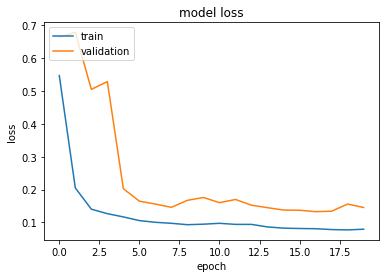

0.9209253191947937

In [65]:
afficher_resultats(history,'dice_loss')# dice loss

Evaluate on test data
1/1 [==============================] - 11s 11s/step - loss: 0.9332 - iou_score: 0.0080 - dice_metric: 0.0668
test loss, test acc: [0.933173656463623, 0.008028579875826836, 0.06682633608579636]


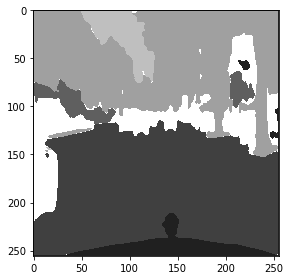

In [66]:
predd = model.predict(X_dataTEST[:1])
#imshow(predd[0][:,:,0])
display_imarge(predd[0])
print("Evaluate on test data")
results = model.evaluate(X_dataTEST, mask_8classTEST, batch_size=128)
print("test loss, test acc:", results)

In [67]:
liste_resultats['Unet_dice_loss'] = {"metric":results[-1],"time":training_time}
#18288

In [68]:
#model.save(My_path+'models_full_DATA/'+'Unet_dice_loss')

### Unet (total loss)


In [69]:
# define model
model = Unet(BACKBONE, encoder_weights='imagenet', classes=8)
model.compile('Adam', loss=total_loss, metrics=[iou_score,dice_metric])

In [70]:
# fit model
start = time.time()
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=16,
    epochs=nb_epochs,
    validation_data=(x_val, y_val)
    )
end = time.time()
training_time = end - start
training_time

Epoch 1/20
50/50 [==============================] - 490s 10s/step - loss: 1.8626 - iou_score: 0.2491 - dice_metric: 0.4837 - val_loss: 2.1867 - val_iou_score: 0.1708 - val_dice_metric: 0.3788
Epoch 2/20
50/50 [==============================] - 490s 10s/step - loss: 0.7578 - iou_score: 0.4604 - dice_metric: 0.7884 - val_loss: 2.1681 - val_iou_score: 0.2037 - val_dice_metric: 0.4231
Epoch 3/20
50/50 [==============================] - 482s 10s/step - loss: 0.5621 - iou_score: 0.5358 - dice_metric: 0.8506 - val_loss: 1.6700 - val_iou_score: 0.2428 - val_dice_metric: 0.5453
Epoch 4/20
50/50 [==============================] - 484s 10s/step - loss: 0.5095 - iou_score: 0.5588 - dice_metric: 0.8670 - val_loss: 0.8687 - val_iou_score: 0.4286 - val_dice_metric: 0.7653
Epoch 5/20
50/50 [==============================] - 482s 10s/step - loss: 0.4659 - iou_score: 0.5783 - dice_metric: 0.8796 - val_loss: 0.9432 - val_iou_score: 0.4102 - val_dice_metric: 0.7510
Epoch 6/20
50/50 [======================

9643.61394071579

0.9168847799301147


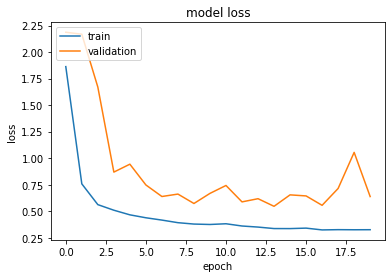

0.9168847799301147

In [71]:
afficher_resultats(history,'total_loss')# total_loss loss

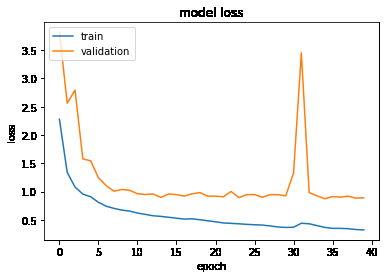
Epoch 40/40
50/50 [==============================] - 616s 12s/step - loss: 0.3228 - iou_score: 0.8397 - dice_metric: 0.9493 - val_loss: 0.8899 - val_iou_score: 0.6333 - val_dice_metric: 0.8675

Evaluate on test data
1/1 [==============================] - 12s 12s/step - loss: 4.6598 - iou_score: 0.0079 - dice_metric: 0.0649
test loss, test acc: [4.659754753112793, 0.007887233048677444, 0.06491350382566452]


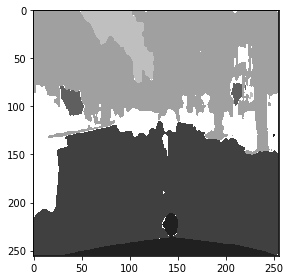

In [72]:
predd = model.predict(X_dataTEST[:1])
display_imarge(predd[0])
print("Evaluate on test data")
results = model.evaluate(X_dataTEST, mask_8classTEST, batch_size=128)
print("test loss, test acc:", results)

In [73]:
liste_resultats['Unet_total_loss'] = {"metric":results[-1],"time":training_time}

In [74]:
#model.save(My_path+'models_full_DATA/'+'Unet_total_loss')

## model retenu/fonction loss retenu/ choix data augmentation

### data augmentation 

In [ ]:
#https://www.tensorflow.org/versions/r2.1/api_docs/python/tf/keras/Model#fit

In [75]:
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

In [263]:
train_gen = seg_gen(x_train, y_train, batch_size)
valid_gen = seg_gen_validation(x_val, y_val, batch_size)

In [264]:
# define model
model = Unet(BACKBONE, encoder_weights='imagenet', classes=8)
model.compile('Adam', loss=dice_loss, metrics=[iou_score,dice_metric])

In [265]:
# fit model
start = time.time()
history = model.fit(
    x=train_gen,
    epochs=nb_epochs,
    validation_data=valid_gen
    )
end = time.time()
training_time = end - start
training_time

Epoch 1/20
50/50 [==============================] - ETA: 0s - loss: 2.3171 - iou_score: 0.1591 - dice_metric: 0.3786 get item !
get item !
get item !
get item !
get item !
get item !
get item !
get item !
50/50 [==============================] - 642s 13s/step - loss: 2.3171 - iou_score: 0.1591 - dice_metric: 0.3786 - val_loss: 5.8127 - val_iou_score: 0.1148 - val_dice_metric: 0.4577
Epoch 2/20
50/50 [==============================] - ETA: 0s - loss: 1.3674 - iou_score: 0.2277 - dice_metric: 0.6268 get item !
get item !
get item !
get item !
get item !
get item !
get item !
50/50 [==============================] - 749s 15s/step - loss: 1.3674 - iou_score: 0.2277 - dice_metric: 0.6268 - val_loss: 2.2440 - val_iou_score: 0.1752 - val_dice_metric: 0.5281
Epoch 3/20
50/50 [==============================] - ETA: 0s - loss: 1.2129 - iou_score: 0.2554 - dice_metric: 0.6793 get item !
get item !
get item !
get item !
get item !
get item !
get item !
50/50 [==============================] - 774s

13094.814435720444

0.7952085733413696


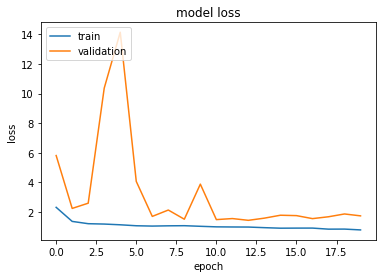

0.7952085733413696

In [266]:
afficher_resultats(history,'total_loss+AUG1')

Evaluate on test data
1/1 [==============================] - 23s 23s/step - loss: 3.5055 - iou_score: 0.0231 - dice_metric: 0.1871
test loss, test acc: [3.5054802894592285, 0.023105967789888382, 0.18706637620925903]


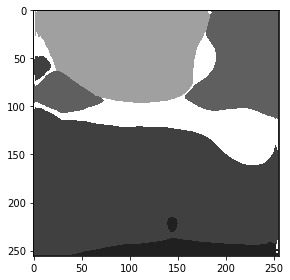

In [267]:
predd = model.predict(X_dataTEST[:1])
display_imarge(predd[0])
print("Evaluate on test data")
results = model.evaluate(X_dataTEST, mask_8classTEST, batch_size=128)
print("test loss, test acc:", results)

In [268]:
liste_resultats['Unet_dataAUG'] = {"metric":results[-1],"time":training_time}

In [81]:
#model.save(My_path+'models_full_DATA/'+'Unet_dataAUG')

# comparaison approches

## dice_metric
on cherche le model qui se rapproche le plus de 1 (qui est l'égalité parfaite entre 2 images)

In [306]:
liste_resultats

{'LinkNet_jaccard': {'metric': 0.057768724858760834,
  'time': 6288.150264501572},
 'FPN_jaccard': {'metric': 0.08055661618709564, 'time': 22460.50908112526},
 'Unet_jaccard': {'metric': 0.05752857029438019, 'time': 8857.301687955856},
 'Unet_vgg16': {'metric': 0.011815889738500118, 'time': 16445.96554660797},
 'Unet_dice_loss': {'metric': 0.06682633608579636, 'time': 9602.320577144623},
 'Unet_total_loss': {'metric': 0.06491350382566452, 'time': 9643.61394071579},
 'Unet_dataAUG': {'metric': 0.18706637620925903, 'time': 13094.814435720444},
 'PSPNet_jaccard': {'metric': 1.1799651247201837e-06,
  'time': 4064.658495903015}}

In [307]:
metrics = [ele["metric"] for ele in liste_resultats.values()]
times = [ele["time"] for ele in liste_resultats.values()]
timesH = [ele/3600 for ele in times]
model_names = [ele for ele in liste_resultats.keys()]

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

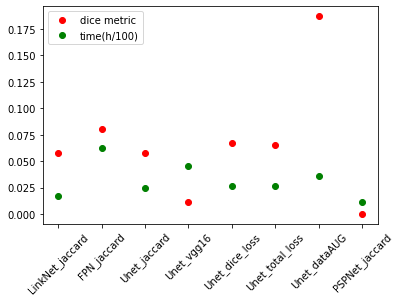

In [308]:
# afficher res
import pandas as pd
import matplotlib.pyplot as plt

df_res = pd.DataFrame(liste_resultats).T

plt.plot(df_res.index, df_res["metric"], 'ro')
plt.plot(df_res.index, df_res["time"]/360000, 'go')

plt.legend(['dice metric','time(h/100)'])
plt.xticks(rotation=45)

Text(0.5, 1.0, 'Dice metric')

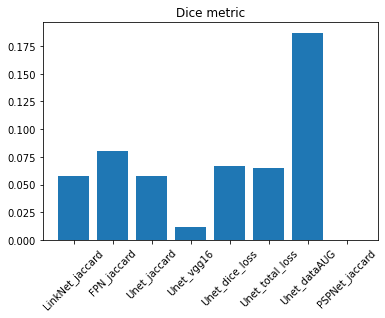

In [309]:
plt.bar(range(len(metrics)), metrics)
plt.xticks(range(len(metrics)), model_names,  rotation = 45)
plt.title("Dice metric")

Text(0.5, 1.0, "Temps d'entrainement (h)")

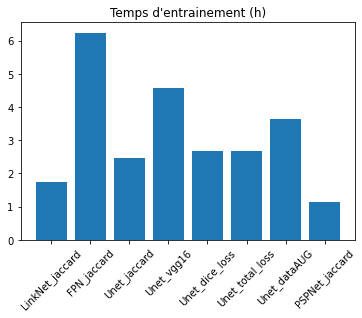

In [310]:
plt.bar(range(len(times)), timesH)
plt.xticks(range(len(times)), model_names,  rotation = 45)
plt.title("Temps d'entrainement (h)")